In [1]:
%matplotlib inline
from scipy.integrate import odeint  
import numpy as np
from matplotlib import pyplot as plt
import random
random.seed(7)
from helper_functions import *

In [2]:
# TEMPLATE TO RUN GILLESPIE SIMULATION OF MODEL

###################
# Helper functions (Do not change!)

def find_index_from_time(t_obs,time,start_index=0):  
    # loop through t_obs array from i=0  
    # stopping when t_obs[i+1] is greater than time  
    # so that t_obs[i] < time < t_obs[i+1]  
    # return i 
    i=start_index
    while i+1<len(t_obs):  
        if t_obs[i+1]>time:
            break
        i=i+1
    # i now stores index corresponding to system at time requested  
    return i 
      
def resample_observations(t_obs_in, s_obs_in, t_obs_out):
    s_obs_out=[] 
    pos=0 
    for time in t_obs_out:  
        i=find_index_from_time(t_obs_in,time, start_index=pos)
        si = s_obs_in[i]  
        s_obs_out.append(si) 
        pos = i
    return s_obs_out


def gen_next_event_time(rate):
    t=random.expovariate(rate)
    return t


def random_choice_from_pdf(pdf):
    cdf=[]
    cumulative_p=0
    for p in pdf:
        cumulative_p+=p
        cdf.append(cumulative_p)
    rand=random.random()

    for i in range(len(cdf)):
        if rand<cdf[i]:
            return i
    # last cdf should be 1.0 so the following should never happen!
    print("Error generating choice, check PDF")
    return None

In [16]:
#define stochastic function
def gillespie_gene_exp(s0,t_obs_out,params):

    #Unpack parameters and species variables
    M1, M2, P1, P2 = s0
    km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, K1, K2, n1, n2 = params

    # create arrays for output
    s_obs=[]
    t_obs=[]

    # read in start time and end time
    t_init=t_obs_out[0]
    t_final=t_obs_out[-1]

    t=t_init
    t_obs.append(t)
    s_obs.append(s0)

    while t < t_final:

        # labels for each event type
        
        types=['M1', 'M2', 'M1_to_P1', 'M2_to_P2', 'M1_to_0','M2_to_0','P1_to_0','P2_to_0']

        # http://localhost:8888/notebooks/Week%2010/stochastic_lowP1highP2.ipynb#rate expressions for each of the events
        
        rate_M1 = km1 * ((K2**n2)/(P2**n2 + K2**n2)) 
        rate_M2 = km2 * ((K1**n1)/(P1**n1 + K1**n1))
        rate_M1_to_P1 = kp1 * M1
        rate_M2_to_P2 = kp2 * M2
        rate_M1_to_0 = kdm1*M1
        rate_M2_to_0 = kdm2*M2
        rate_P1_to_0 = kdp1*P1
        rate_P2_to_0 = kdp2*P2
        
        # store the rates into a list
        
        rates=[rate_M1, rate_M2, rate_M1_to_P1, rate_M2_to_P2, rate_M1_to_0, 
               rate_M2_to_0, rate_P1_to_0, rate_P2_to_0]

        ## CARRY OUT GILLESPIE ALGORITHM TO STEP FORWARD TO NEXT EVENT
        ## AND UPDATE SYSTEM STATE ACCORDING TO EVENT TYPE

        # calc total reaction rate
        rate_all_events=sum(rates)

        # if rate of events is zero break from loop
        # e.g. when all reactants used up
        if rate_all_events==0:
            break

        # generate the time until the next event
        # in accordance with rate_all_events
        next_event=gen_next_event_time(rate_all_events)

        # calc PDF for event type
        # in accordance with relative rates
        pdf=[]
        for event_rate in rates:
            p_event = event_rate/sum(rates)
            pdf.append(p_event)

        rand_i =  random_choice_from_pdf(pdf)
        event_type=types[rand_i]

        # increment time and number of molecules
        # according to event type
        t=t+next_event

        #-----------------------------------#

        ## ALGORITHM HAS INCREMENTED TIME AND SELECTED NEXT EVENT
        ## WE NOW NEED TO UPDATE OUR SYSTEM ACCORDING TO THE EVENT
        ## TYPE STORED IN VARIABLE event_type

        # if-elif-else commands to update the system
        
        # types=['M1', 'M2', 'M1_to_P1', 'M2_to_P2', 'M1_to_0','M2_to_0','P1_to_0','P2_to_0', ]
        
        if event_type=='M1':
            M1+=1
        elif event_type=='M2':
            M2+=1
        elif event_type=='M1_to_P1':
            P1+=1
        elif event_type=='M2_to_P2':
            P2+=1
        elif event_type=='M1_to_0':
            M1-=1
        elif event_type=='M2_to_0':
            M2-=1
        elif event_type=='P1_to_0':
            P1-=1
        elif event_type=='P2_to_0':
            P2-=1
        else:
            print("error unknown event type!!")

        # store observation of all species in model for observation
        
        s0= M1,M2,P1,P2
        
        t_obs.append(t)
        s_obs.append(s0)

        # loops until time t exceeds t_final

    # loop has ended

    # before we return the results we must
    # resample the output to provide observations in accordance
    # with the t_obs passed to the function
    s_obs_out=resample_observations(t_obs,s_obs,t_obs_out)
    return np.array(s_obs_out)


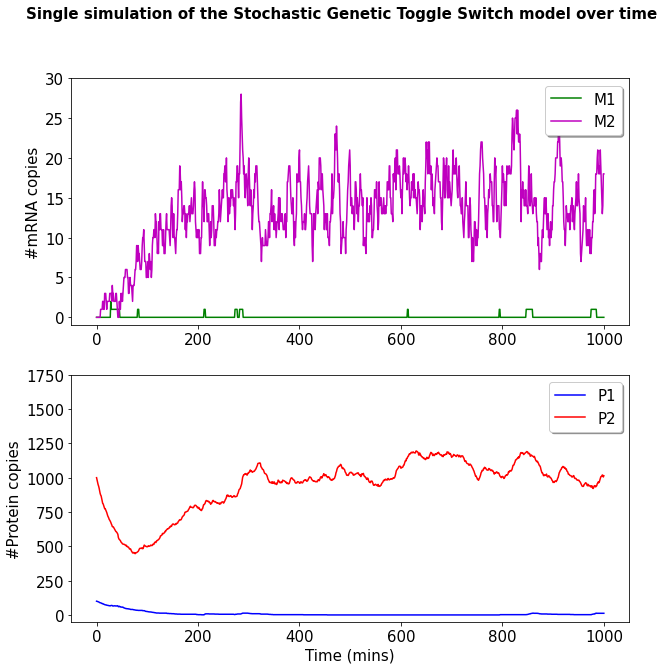

In [17]:
# Figure 11B
#Plot of the stochastic system behaviour over time  

# Set initial conditions and parameters
M1=0.0
M2=0.0
P1=100
P2=1000

#params
kp1= 0.9726
kp2= 1.170
kdp1 = 0.0165
kdp2 = 0.0165
K1 = 31.94
K2 = 30.0
n1 = 2.0
n2 = 2.0
km1= 8.3
km2= 2.06
kdm1 = 0.1386
kdm2 = 0.1386

s0=(M1,M2,P1,P2)
params = (km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, K1, K2, n1, n2)

t_max=1000
t_obs=np.linspace(0,t_max,t_max+1)

# Run simulation of the model
s_obs=gillespie_gene_exp(s0,t_obs,params)

M1_obs=s_obs[:,0]
M2_obs=s_obs[:,1]
P1_obs=s_obs[:,2]
P2_obs=s_obs[:,3]

# Plot results 

fig = plt.figure(figsize=(10,10))
fig.suptitle('Single simulation of the Stochastic Genetic Toggle Switch model over time', 
              fontsize=15, fontweight='bold', y=0.98)
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.set_ylabel('#mRNA copies')
ax2.set_ylabel('#Protein copies')
ax2.set_xlabel('Time (mins)')

ax1.plot(t_obs, M1_obs, 'g-', label ='M1')
ax1.plot(t_obs, M2_obs, 'm-', label ='M2')
ax2.plot(t_obs, P1_obs, 'b-', label ='P1')
ax2.plot(t_obs, P2_obs, 'r-', label ='P2')

ax1.set_ylim(-1,30)
ax2.set_ylim(-50,1750)

ax1.legend(loc = 1, prop={'size': 15}, shadow=True)
ax2.legend(loc = 1, prop={'size': 15}, shadow=True)

ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

plt.savefig('fig11B.png');

In [14]:
# Figure 12 and 13

# DEFINE INITIAL CONDITIONS AND PARAMETERS
M1=0.0
M2=0.0
P1=100
P2=1000

kp1= 0.9726
kp2= 1.170
kdp1 = 0.0165
kdp2 = 0.0165
K1 = 31.94
K2 = 30.0
n1 = 2.0
n2 = 2.0
km1= 8.3
km2= 2.06
kdm1 = 0.1386
kdm2 = 0.1386

s0 = (M1,M2,P1,P2)
params = (km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, K1, K2, n1, n2)

t_max = 1000
t_obs=np.linspace(0,t_max,t_max+1)

# RUN SIMULATIONS 5 runs or 200 runs
#n_runs = 5
n_runs = 200
M1_runs=[]
M2_runs=[]
P1_runs=[]
P2_runs=[]

for i in range(n_runs):
    print("Simulating {} of {} runs...".format(i+1,n_runs))
    s_obs=gillespie_gene_exp(s0,t_obs,params)
    
    M1_obs=s_obs[:,0]
    M2_obs=s_obs[:,1]
    P1_obs=s_obs[:,2]
    P2_obs=s_obs[:,3]
    
    M1_runs.append(M1_obs)
    M2_runs.append(M2_obs)
    P1_runs.append(P1_obs)
    P2_runs.append(P2_obs)

M1_runs = np.array(M1_runs)
M2_runs = np.array(M2_runs)
P1_runs = np.array(P1_runs)
P2_runs = np.array(P2_runs)

Simulating 1 of 200 runs...
Simulating 2 of 200 runs...
Simulating 3 of 200 runs...
Simulating 4 of 200 runs...
Simulating 5 of 200 runs...
Simulating 6 of 200 runs...
Simulating 7 of 200 runs...
Simulating 8 of 200 runs...
Simulating 9 of 200 runs...
Simulating 10 of 200 runs...
Simulating 11 of 200 runs...
Simulating 12 of 200 runs...
Simulating 13 of 200 runs...
Simulating 14 of 200 runs...
Simulating 15 of 200 runs...
Simulating 16 of 200 runs...
Simulating 17 of 200 runs...
Simulating 18 of 200 runs...
Simulating 19 of 200 runs...
Simulating 20 of 200 runs...
Simulating 21 of 200 runs...
Simulating 22 of 200 runs...
Simulating 23 of 200 runs...
Simulating 24 of 200 runs...
Simulating 25 of 200 runs...
Simulating 26 of 200 runs...
Simulating 27 of 200 runs...
Simulating 28 of 200 runs...
Simulating 29 of 200 runs...
Simulating 30 of 200 runs...
Simulating 31 of 200 runs...
Simulating 32 of 200 runs...
Simulating 33 of 200 runs...
Simulating 34 of 200 runs...
Simulating 35 of 200 ru

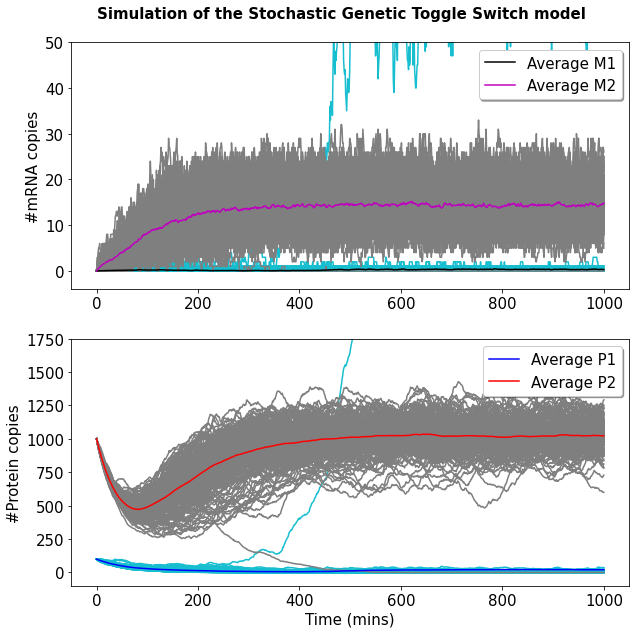

In [15]:
# Plot results
fig_runs=plt.figure(figsize=(10,10))
fig_runs.suptitle('Simulation of the Stochastic Genetic Toggle Switch model', 
              fontsize=15, fontweight='bold', y=0.93)
ax1=fig_runs.add_subplot(2,1,1)
ax2=fig_runs.add_subplot(2,1,2)

ax1.plot(t_obs, M1_runs.T,'tab:cyan')
ax1.plot(t_obs, M2_runs.T,'tab:gray')
ax2.plot(t_obs, P1_runs.T,'tab:cyan')
ax2.plot(t_obs, P2_runs.T,'tab:gray')

# Plot the average trendline
av_M1 = np.average(M1_runs, axis=0)
ax1.plot(t_obs, av_M1,'k-', label='Average M1')
av_M2 = np.average(M2_runs, axis=0)
ax1.plot(t_obs, av_M2,'m-',label='Average M2')

av_P1 = np.average(P1_runs, axis=0)
ax2.plot(t_obs, av_P1,'b-',label='Average P1')
av_P2 = np.average(P2_runs, axis=0)
ax2.plot(t_obs, av_P2,'r-',label='Average P2')

# Adjust labels
ax1.set_ylabel('#mRNA copies')
ax2.set_ylabel('#Protein copies')
ax2.set_xlabel('Time (mins)')

ax1.set_ylim(-4,50)
ax2.set_ylim(-100,1750)

ax1.legend(loc = 1, prop={'size': 15}, shadow=True)
ax2.legend(loc = 1, prop={'size': 15}, shadow=True)

ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

#plt.savefig('fig12_lowP1.png');
plt.savefig('fig13_lowP1.png');

In [21]:
# DEFINE INITIAL CONDITIONS AND PARAMETERS
M1=0.0
M2=0.0
P1=100
P2=1000

kp1= 0.9726
kp2= 1.170
kdp1 = 0.0165
kdp2 = 0.0165
K1 = 31.94
K2 = 30.0
n1 = 2.0
n2 = 2.0
km1= 8.3
km2= 2.06
kdm1 = 0.1386
kdm2 = 0.1386

s0 = (M1,M2,P1,P2)
params = (km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, K1, K2, n1, n2)

t_max = 6000
t_obs=np.linspace(0,t_max,t_max+1)

# RUN SIMULATIONS
n_runs = 200
M1_runs=[]
M2_runs=[]
P1_runs=[]
P2_runs=[]

for i in range(n_runs):
    print("Simulating {} of {} runs...".format(i+1,n_runs))
    s_obs=gillespie_gene_exp(s0,t_obs,params)
    
    M1_obs=s_obs[:,0]
    M2_obs=s_obs[:,1]
    P1_obs=s_obs[:,2]
    P2_obs=s_obs[:,3]
    
    M1_runs.append(M1_obs)
    M2_runs.append(M2_obs)
    P1_runs.append(P1_obs)
    P2_runs.append(P2_obs)

M1_runs = np.array(M1_runs)
M2_runs = np.array(M2_runs)
P1_runs = np.array(P1_runs)
P2_runs = np.array(P2_runs);

Simulating 1 of 200 runs...
Simulating 2 of 200 runs...
Simulating 3 of 200 runs...
Simulating 4 of 200 runs...
Simulating 5 of 200 runs...
Simulating 6 of 200 runs...
Simulating 7 of 200 runs...
Simulating 8 of 200 runs...
Simulating 9 of 200 runs...
Simulating 10 of 200 runs...
Simulating 11 of 200 runs...
Simulating 12 of 200 runs...
Simulating 13 of 200 runs...
Simulating 14 of 200 runs...
Simulating 15 of 200 runs...
Simulating 16 of 200 runs...
Simulating 17 of 200 runs...
Simulating 18 of 200 runs...
Simulating 19 of 200 runs...
Simulating 20 of 200 runs...
Simulating 21 of 200 runs...
Simulating 22 of 200 runs...
Simulating 23 of 200 runs...
Simulating 24 of 200 runs...
Simulating 25 of 200 runs...
Simulating 26 of 200 runs...
Simulating 27 of 200 runs...
Simulating 28 of 200 runs...
Simulating 29 of 200 runs...
Simulating 30 of 200 runs...
Simulating 31 of 200 runs...
Simulating 32 of 200 runs...
Simulating 33 of 200 runs...
Simulating 34 of 200 runs...
Simulating 35 of 200 ru

In [22]:
#calculate CV = sd/mean

std_m1 = np.std(M1_runs)
std_m2 = np.std(M2_runs)
std_p1 = np.std(P1_runs)
std_p2 = np.std(P2_runs)

mean_m1 = np.mean(M1_runs)
mean_m2 = np.mean(M2_runs)
mean_p1 = np.mean(P1_runs)
mean_p2 = np.mean(P2_runs)

cv_m1 = std_m1/mean_m1
cv_m2 = std_m2/mean_m2
cv_p1 = std_p1/mean_p1
cv_p2 = std_p2/mean_p2

max_m1 = np.max(M1_runs)
max_m2 = np.max(M2_runs)
max_p1 = np.max(P1_runs)
max_p2 = np.max(P2_runs)

print(f"Standard deviation of M1 is {std_m1:.2f}, M2 is {std_m2:.2f}, P1 is {std_p1:.2f} and P2 is {std_p2:.2f}.")
print(f"Mean of M1 is {mean_m1:.2f}, M2 is {mean_m2:.2f}, P1 is {mean_p1:.2f} and P2 is {mean_p2:.2f}.")
print(f"CV of M1 is {cv_m1:.2f}, M2 is {cv_m2:.2f}, P1 is {cv_p1:.2f} and P2 is {cv_p2:.2f}.")

print(max_m1)
print(max_m2)
print(max_p1)
print(max_p2)


Standard deviation of M1 is 4.14, M2 is 4.27, P1 is 239.86 and P2 is 154.35.
Mean of M1 is 0.34, M2 is 14.15, P1 is 20.86 and P2 is 1003.45.
CV of M1 is 12.13, M2 is 0.30, P1 is 11.50 and P2 is 0.15.
86.0
38.0
4002.0
1530.0


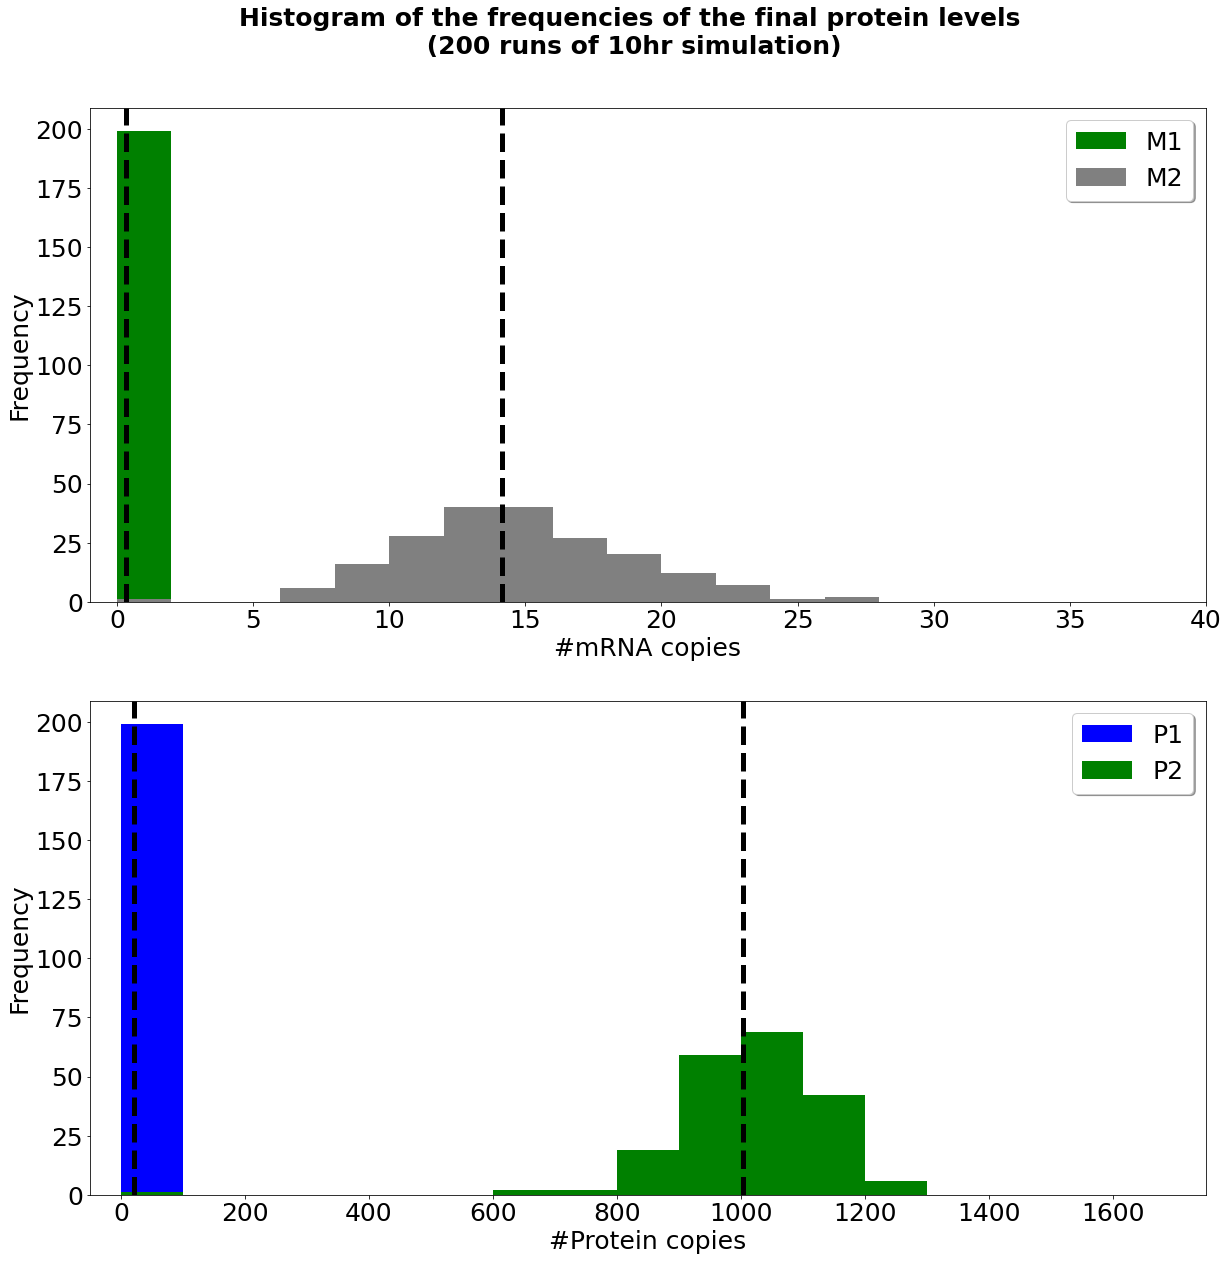

In [23]:
# Figure 14
# Plot histogram

fig_hist=plt.figure(figsize=(20,20))
fig_hist.suptitle('Histogram of the frequencies of the final protein levels\n (200 runs of 10hr simulation)', fontsize=25, fontweight='bold', y=0.95)

ax1=fig_hist.add_subplot(2,1,1)
ax2=fig_hist.add_subplot(2,1,2)

ax1.hist(M1_runs.T[-1],bins=np.arange(0,100,2), color = 'green', label='M1')
ax1.hist(M2_runs.T[-1],bins=np.arange(0,100,2), color = 'gray', label = 'M2')
ax2.hist(P1_runs.T[-1],bins=np.arange(0,4000,100), color = 'blue', label='P1')
ax2.hist(P2_runs.T[-1],bins=np.arange(0,4000,100), color = 'green', label='P2')

ax1.axvline(M1_runs.mean(), color='k', linestyle='dashed', linewidth=5)
ax1.axvline(M2_runs.mean(), color='k', linestyle='dashed', linewidth=5)
ax2.axvline(P1_runs.mean(), color='k', linestyle='dashed', linewidth=5)
ax2.axvline(P2_runs.mean(), color='k', linestyle='dashed', linewidth=5)

ax1.set_xlabel('#mRNA copies')
ax2.set_xlabel('#Protein copies')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')

ax1.set_xlim(-1,40)
ax2.set_xlim(-50,1750)

ax1.legend(loc = 1, prop={'size': 25}, shadow=True)
ax2.legend(loc = 1, prop={'size': 25}, shadow=True)
ax1.xaxis.label.set_size(25)
ax1.yaxis.label.set_size(25)
ax1.xaxis.set_tick_params(labelsize=25)
ax1.yaxis.set_tick_params(labelsize=25)
ax2.xaxis.label.set_size(25)
ax2.yaxis.label.set_size(25)
ax2.xaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)

plt.savefig('fig14A.png');

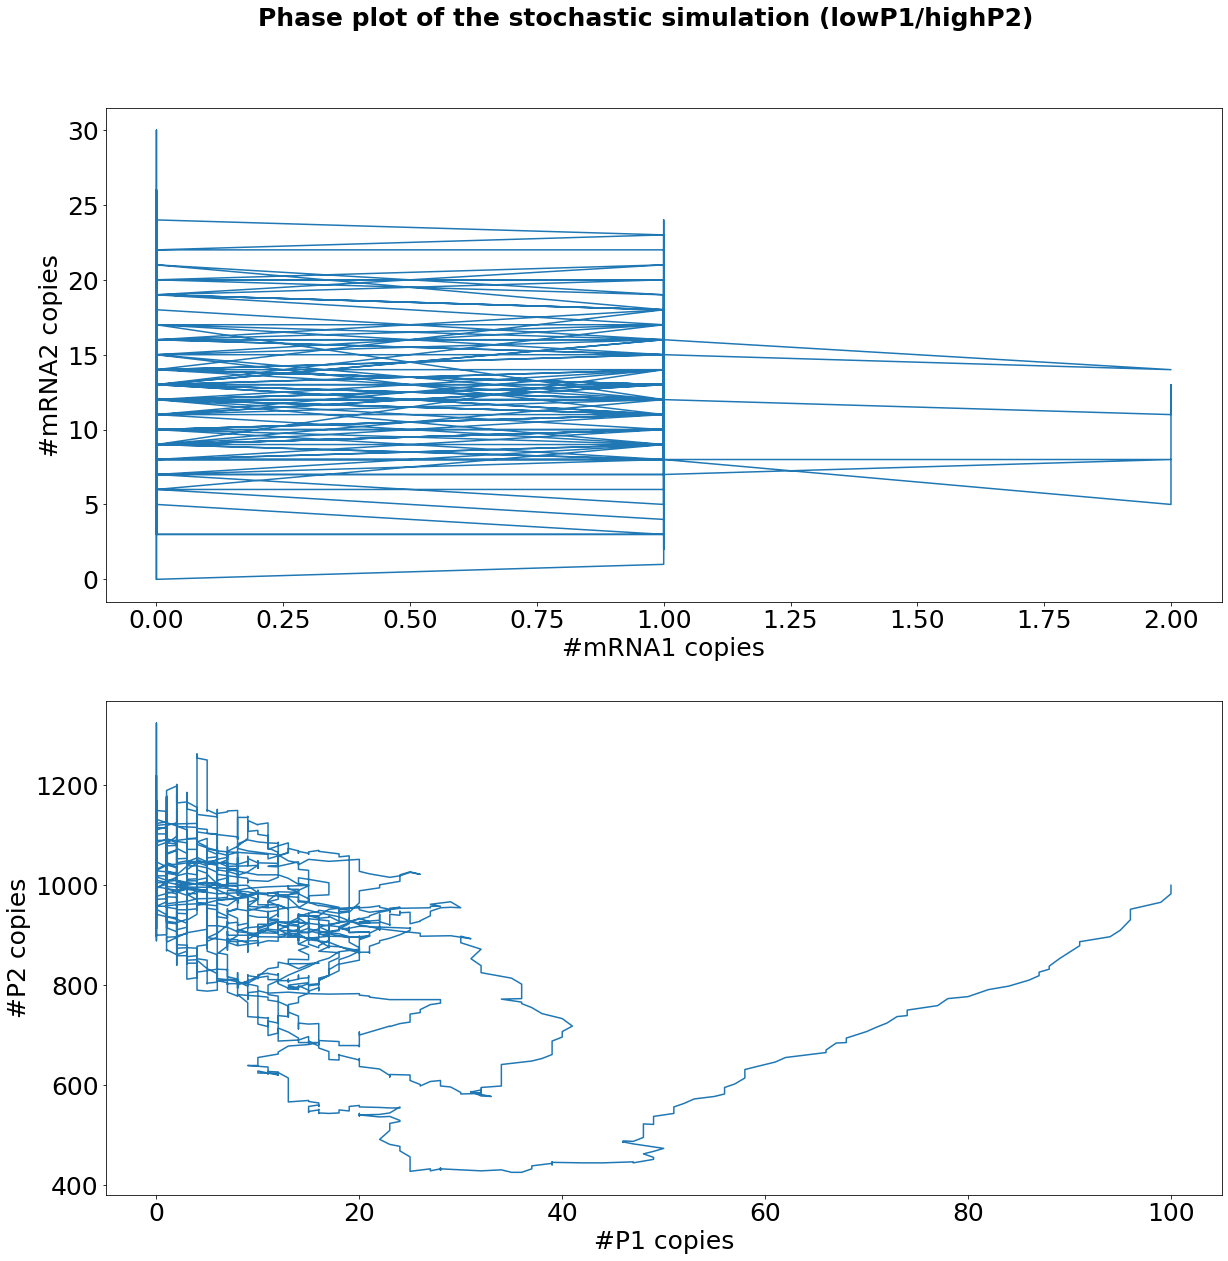

In [10]:
# Phase plot

fig = plt.figure(figsize=(20,20))
fig.suptitle('Phase plot of the stochastic simulation (lowP1/highP2)', fontsize=25, fontweight='bold', y=0.95)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(M1_runs[0], M2_runs[0])
ax2.plot(P1_runs[0], P2_runs[0])


ax1.set_xlabel('#mRNA1 copies')
ax1.set_ylabel('#mRNA2 copies')
ax2.set_xlabel('#P1 copies')
ax2.set_ylabel('#P2 copies')

ax1.xaxis.label.set_size(25)
ax1.yaxis.label.set_size(25)
ax1.xaxis.set_tick_params(labelsize=25)
ax1.yaxis.set_tick_params(labelsize=25)
ax2.xaxis.label.set_size(25)
ax2.yaxis.label.set_size(25)
ax2.xaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)

plt.savefig('stochasticphaseplot_P1low.png');

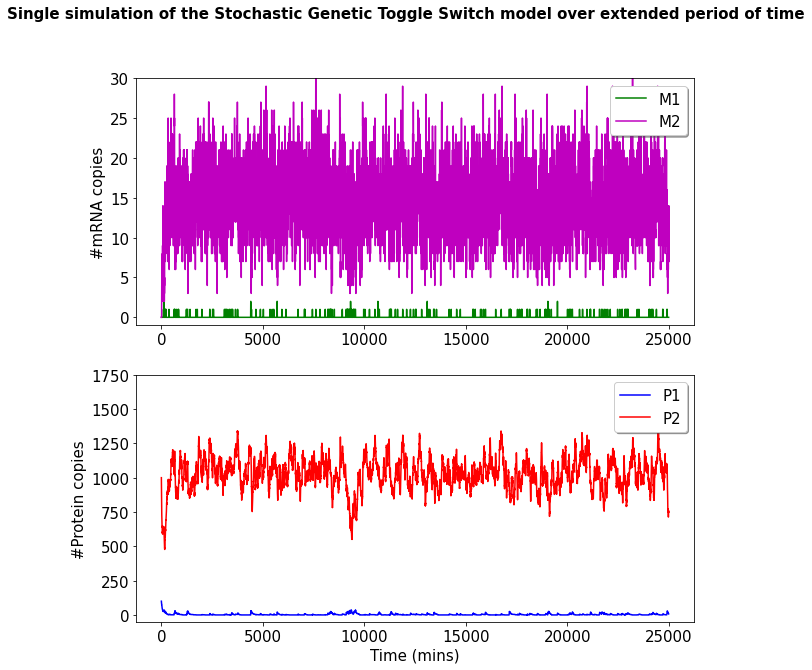

In [11]:
# Plot of the stochastic system behaviour over extended period of time  

# Set initial conditions and parameters
M1=0.0
M2=0.0
P1=100
P2=1000

# params
kp1= 0.9726
kp2= 1.170
kdp1 = 0.0165
kdp2 = 0.0165
K1 = 31.94
K2 = 30.0
n1 = 2.0
n2 = 2.0
km1= 8.3
km2= 2.06
kdm1 = 0.1386
kdm2 = 0.1386

s0=(M1,M2,P1,P2)
params = (km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, K1, K2, n1, n2)

t_max= 25000
t_obs=np.linspace(0,t_max,t_max+1)

# Run simulation of the model
s_obs=gillespie_gene_exp(s0,t_obs,params)

M1_obs=s_obs[:,0]
M2_obs=s_obs[:,1]
P1_obs=s_obs[:,2]
P2_obs=s_obs[:,3]

# Plot results 

fig = plt.figure(figsize=(10,10))
fig.suptitle('Single simulation of the Stochastic Genetic Toggle Switch model over extended period of time', 
              fontsize=15, fontweight='bold', y=0.98)
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.set_ylabel('#mRNA copies')
ax2.set_ylabel('#Protein copies')
ax2.set_xlabel('Time (mins)')

ax1.plot(t_obs, M1_obs, 'g-', label ='M1')
ax1.plot(t_obs, M2_obs, 'm-', label ='M2')
ax2.plot(t_obs, P1_obs, 'b-', label ='P1')
ax2.plot(t_obs, P2_obs, 'r-', label ='P2')

ax1.set_ylim(-1,30)
ax2.set_ylim(-50,1750)

ax1.legend(loc = 1, prop={'size': 15}, shadow=True)
ax2.legend(loc = 1, prop={'size': 15}, shadow=True)

ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

plt.savefig('extendedstochasticplot.png');